<a href="https://colab.research.google.com/github/amanjaiswal777/Sentiment_Analysis/blob/main/bert_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
from multiprocessing import Pool
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import multiprocessing
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import config

In [ ]:
path = Path('')
assert path.exists()

In [ ]:
!ls {path}

balanced_simplified_reviews_full.pkl  sample_data
config.py			      yelp_reviews_simple_8021122.json
__pycache__


In [ ]:
balanced_simplified_reviews = pd.read_pickle(path/'balanced_simplified_reviews_full.pkl')

In [ ]:
balanced_simplified_reviews['stars'] = balanced_simplified_reviews['stars'] - 1
balanced_simplified_reviews

,text,stars
2,I've stayed at many Marriott and Renaissance M...,1
5,"The setting is perfectly adequate, and the foo...",1
10,Disappointing. Bolt is a follow up of Fanny's ...,1
25,"When we first arrived at the Coco Key, we were...",1
40,"I wanted this to be a great place, but I wasn'...",1
...,...,...
9995,This is a really cool place that has a lot of ...,3
9996,"I thought this place would be good because, on...",3
9997,Coast is one of my go-to Happy Hour joints. T...,3
9998,I love that their pearls are made in house. Th...,4


### Prepare tokenizer and data loaders

In [ ]:
NUM_CLASSES = len(balanced_simplified_reviews['stars'].unique())

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

In [ ]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(tokenizer.encode(t, max_length=config.MAX_LENGTH)))
    return df

In [ ]:
%%time

balanced_simplified_reviews = parallelize_dataframe(balanced_simplified_reviews, count_tokens, 10)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

CPU times: user 79.4 ms, sys: 93.7 ms, total: 173 ms
Wall time: 1.84 s


Checking the distribution of the length of tokens

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


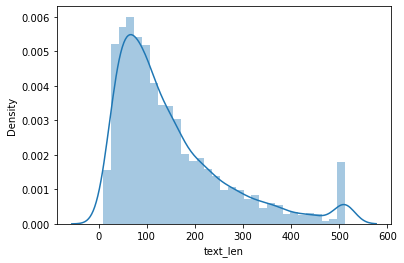

In [ ]:
sns.distplot(balanced_simplified_reviews['text_len'])

In [ ]:
class YelpDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews, self.targets,  self.tokenizer, self.max_len = reviews.to_numpy(), targets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review': review,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'target': torch.tensor(self.targets[item]).long()
        }

In [ ]:
RANDOM_SEED = 42

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
train_df, test_df = train_test_split(balanced_simplified_reviews, test_size=0.1, random_state=RANDOM_SEED, 
                                     stratify=balanced_simplified_reviews.stars.values)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, stratify=test_df.stars.values)
train_df.shape, test_df.shape, valid_df.shape

((3861, 3), (215, 3), (215, 3))

Checking if the distribution is even. We used `stratify` so it should be.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


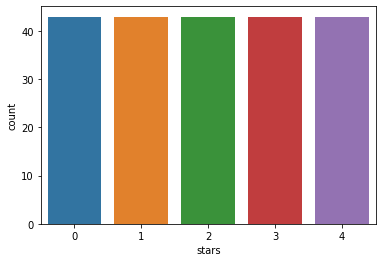

In [ ]:
sns.countplot(valid_df['stars'])

In [ ]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = YelpDataset(df['text'], df['stars'], tokenizer, max_length)
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=multiprocessing.cpu_count() - 1
    )

In [ ]:
BATCH_SIZE=16

train_dl = create_data_loader(train_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
test_dl = create_data_loader(test_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
valid_dl = create_data_loader(valid_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)

In [ ]:
sample_record = next(iter(train_dl))
sample_record['input_ids'][0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([  101,  1188,  1282,  1110,  1632,   119,  1109,  1160,  9834,  1116,
         1132,   170,  2337,  1105,  1152,  1815, 21620,  1193,  1107,  1103,
         3119,  1487,   119,  1135,   112,   188,  1176,  1152,  1132,  1543,
         1893,  1229,  1152,  9834,   119,  1220,  1138,   170,  2951,  1115,
         1867,  4268,  1129,  5351,  1112,  1195,  1294,  1155,  2094,  4489,
         1121, 14515,   119,  1135,  1108, 13108,  1105,  1103,  1436,  1497,
        17458,  1213,   106,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
sample_record['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Prepare training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [ ]:
model = BertForSequenceClassification.from_pretrained(config.PRE_TRAINED_MODEL_NAME, num_labels = NUM_CLASSES, 
                                                      output_attentions = False, output_hidden_states = False)
model = model.to(device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
len([p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]), len([p for n, p in param_optimizer if any(nd in n for nd in no_decay)])

(77, 124)

In [ ]:
# AdamW Adam algorithm with weight decay fix
optimizer = AdamW(optimizer_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [ ]:
EPOCHS = 3

total_steps = len(train_dl) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import os
import shutil
import pickle

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

def save_model(model, tokenizer, output_dir = path/'model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model')

### Training Loop

In [ ]:
def grab_batch_data(batch):
    input_ids = batch['input_ids'].to(device)
    input_mask = batch['attention_mask'].to(device)
    labels = batch['target'].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(valid_dl, total=len(valid_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            (loss, logits) = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dl)
    avg_val_loss = total_eval_loss / len(valid_dl)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [ ]:
training_stats = []
best_accuracy = 0
for epoch in tqdm(range(0, EPOCHS), total=EPOCHS):
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        model.zero_grad()  
        loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)
        total_train_loss += loss.item()
        if step % 2000 == 0:
            print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dl)
    print("")
    print(f"  Average training loss: {avg_train_loss}")
    stats_info = eval_fn()
    stats_info['epoch'], stats_info['Average training loss'] = epoch, avg_train_loss
    training_stats.append(stats_info)
    save_model(model, tokenizer, output_dir=path/f'output_dir_{epoch}')
    if stats_info['Accuracy'] > best_accuracy:
        save_model(model, tokenizer, output_dir=path/f'output_dir_best')
        best_accuracy = stats_info['Accuracy']

  0%|          | 0/3 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-sty

  0%|          | 0/242 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/aman/anaconda3/envs/task2/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats

,Accuracy,Validation Loss,epoch,Average training loss
0,0.694750,0.702295,0,0.737298
1,0.705091,0.711050,1,0.627666
2,0.707941,0.722049,2,0.540407


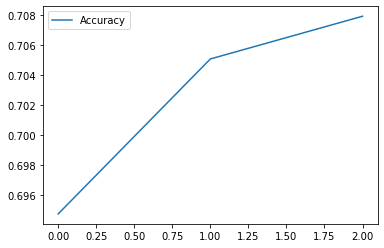

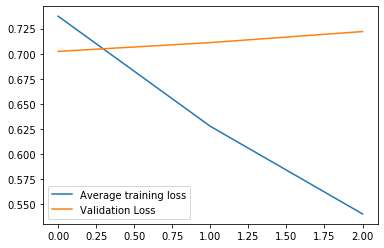

In [ ]:
df_stats[['Accuracy']].plot(); df_stats[['Average training loss',  'Validation Loss']].plot()

In [ ]:
input_ids, input_mask, labels = grab_batch_data(next(iter(valid_dl)))

In [ ]:
loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)